In [1]:
# import libraries
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from textblob import TextBlob
try:
    import subprocess
except:
    %pip install subprocess
    import subprocess
import numpy as np

In [2]:
import findspark
findspark.init('C:\spark\spark')
# import necessary packages
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
sc = SparkContext()
# we initiate the StreamingContext with 10 second batch interval. #next we initiate our sqlcontext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)




# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)
# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
lines = socket_stream.window(60)

In [3]:
from collections import namedtuple

fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )

fields2 = ("text", "count")
Sentiment = namedtuple('Sentiment', fields2)

# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( "\n" ) ) #Splits to a list containing of the single tweets 
  .map( lambda word: ( word, 1) ) 
  .map( lambda rec: Sentiment( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
  .limit(50).registerTempTable("sentiment") ) )
    #  hier: alle texte müssen raus und schleife braucht viel zu lange...

# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  # Checks for    hashtag calls  
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
 # Stores in a Tweet Object
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 # Registers only top 10 hashtags to a table.
  .limit(5).registerTempTable("tweets") ) )

In [ ]:
while True:
    search = input("Enter searchword: ")
    if(search != ""):
        print("Search for: " + search)
        break
    print("You have to use a searchword!")

search = search.split(",")

#overwrite file
f = open("var.py", "w")
f.write("search = %s" % search)
f.close()

file = subprocess.Popen("job.sh", shell = True)

ssc.start()

Enter searchword: beach, sun, sea
Search for: beach, sun, sea


In [ ]:
print("Wait 60 seconds stream to start properly...")
time.sleep(60)
print("...successfull")

Wait 60 seconds stream to start properly...
...successfull


In [ ]:
def plot():
    try:
        error = 0
        %matplotlib inline
        while True:
            print("Gather Data for graph...")
            time.sleep(5)
            # top hashtags:
            top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
            top_10_df = top_10_tags.toPandas()
            print("successful")
            print("plotting")
            #display.clear_output(wait=True)
            plt.figure( figsize = ( 10, 8 ) )
            sns.barplot( x="count", y="hashtag", data=top_10_df)
            plt.show()
            sentiment()
    except:
        print("Data was not ready for printing....waiting....")
        time.sleep(20)
        error += 1
        if(error >= 5):
            print("Error on Streaming")
            ssc.stop()
            exit()
        plot()
        
def sentiment():
    %matplotlib inline
    error = 0
    try:
        print("Gater data for Sentiment Analysis...")
        #sentiment analysis:
        top_10_senti = sqlContext.sql( 'Select text from sentiment' )
        top_10_s = top_10_senti.toPandas()
        print("successful")
        #print(top_10_s)
        # Schleife über alle texte, die in top_10_s gespeichert sind, und davon jeweils die sentiment analysis
        n = 51
        positiveList = [] #empty list for storing positive tweets
        negativeList = [] #empty list for storing negative tweets
        countPosNeg = np.array([0, 0]) #array for counting positive and negative tweets --> 1 is positive, 0 is negative
        countNames = np.array(["negative", "positive"]) #names for plotting
        s = 0
        i = 1
        print("analyse text for sentiment...")
        while i <= n:
            opinion = TextBlob(top_10_s["text"][i])
            if(opinion.sentiment[0] == 0.0 and opinion.sentiment[1] == 0.0): #text is not suitable for sentiment
                i += 1
                s += 1
            else:
                if(s <= 5):
                    print("For the text: ", top_10_s["text"][i])
                    print("The text polarity is: %.2f" %opinion.sentiment[0])
                    print("The text subjectivity is: %.2f" %opinion.sentiment[1])
                    print("*****************************************************")
                if(opinion.sentiment[0] > 0):
                    countPosNeg[1] += 1 #add 1 to positive count because sentiment was positive
                    positiveList.append(opinion.sentiment[0])
                else:
                    countPosNeg[0] += 1 #add 1 to negatvie count because seintiment was negative
                    negativeList.append(opinion.sentiment[0])
                i += 1
                s += 1
        plt.figure( figsize = ( 10, 8 ))
        sns.barplot( x=countNames, y=countPosNeg)
        plt.show()
        
        plt.figure( figsize = ( 10, 8 ))
        sns.boxplot( y=countNames, x=[positiveList, negativeList])
        plt.show()
        if(input("continue?(y/n): ") == "y"):
            sentiment()
        else:
            ssc.stop()
            exit()
    except:
        print("Data was not ready for sentiment...waiting...")
        time.sleep(20)
        if(error >= 5):
            print("Error on sentiment, getting not enough data!")
            ssc.stop()
            exit()
        error += 1
        sentiment()

Gather Data for graph...
successful
plotting


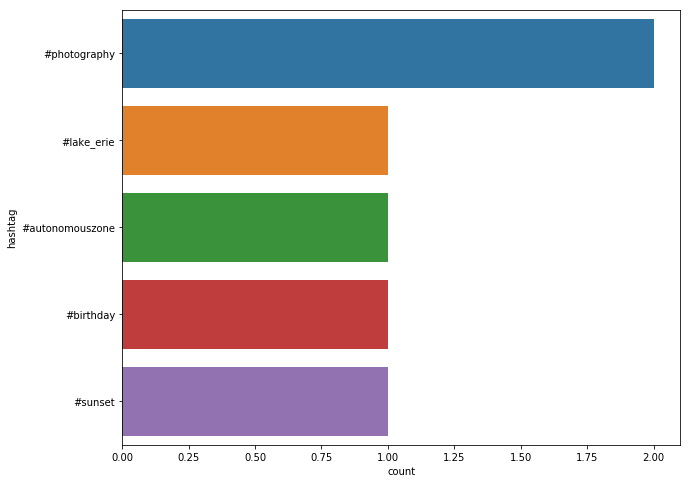

Gater data for Sentiment Analysis...
successful
analyse text for sentiment...
For the text:  https://t.co/jUBTyKKoxORT @FinlayPringle: Out to Ardmair yesterday for another lovely afternoon snorkel. Water clarity was amazing, never seen so many comb jellyf…RT @LonerMike_: Bitch are u not already there??RT @MayorJenny: Seattle is fine. Don’t be so afraid of democracy.RT @LonerMike_: Bitch are u not already there??RT @LonerMike_: Bitch are u not already there??@GerryCox Good point Gerry. I must say, I didn't see many of them at Leics v Gloucs at Grace Rd last summer.RT @realTrumpForce: DUMMY DURKAN!
The text polarity is: 0.33
The text subjectivity is: 0.59
*****************************************************
For the text:  Apr = April… https://t.co/yo7KB0zdH3Watch MJKO squad member Ozzy teaching us how to make a delicious summer treat. Thanks Ozzy and this wonderful mom L… https://t.co/pP0ijiBkGnEnjoy the frogs singing and the lotus flowers in Heian-Kyo with the Grain Rain/Beginning of S

In [ ]:
plot()